In [159]:
import numpy as np
import pandas as pd
import json
import re

In [160]:
#Dictionary of data from a class
def get_generation_data_template():
    return {
    'clazz': '',
    'line_coverage': 0, 
    'branch_coverage': 0,
    'generated_tests': 0,
    'test_suite_coverage': 0,
    'mutation_score': 0,
    'killed_mutants': [],
    'survived_mutants': []
}

In [161]:
def process_file(lines):
    results = []
    cls_data = {}
    mutants = False
    for line in lines: 
        complete = False
        if not line.strip().startswith('[') and line != '': 
            if(line.startswith('* Current class:')): 
                cls_data = get_generation_data_template()
            if(line.startswith('* Going to generate')):
                cls_data['clazz'] = line.split(':')[1].strip()
            if(line.startswith('* Coverage of criterion LINE')):
                cls_data['line_coverage'] = line.split(':')[1].split('%')[0].strip()
            if(line.startswith('* Coverage of criterion BRANCH')):
                cls_data['branch_coverage'] = line.split(':')[1].split('%')[0].strip()
            if(line.startswith('* Generated')):
                cls_data['generated_tests'] = line.split(' ')[2].strip()
            if(line.startswith('* Resulting test suite\'s coverage')):
                cls_data['test_suite_coverage'] = line.split(':')[1].split('%')[0].strip()
            if(line.startswith('* Resulting test suite\'s mutation')):
                cls_data['mutation_score'] = line.split(':')[1].split('%')[0].strip()
            if(line.startswith('-->') and not complete):
                try:
                    status = line.split('Status:')[1].strip()
                    if(status == 'Survived'):
                        cls_data['survived_mutants'].append(line.strip())
                    if(status == 'Killed'):
                        cls_data['killed_mutants'].append(line.strip())
                except:
                    pass

            if(line.startswith('* Done!')):
                complete = True
                results.append(cls_data)
    return results

In [162]:
def obtain_resume_dict(file):
    generation_results = open(file, "r", encoding='utf-16')
    lines = generation_results.readlines()
    results = process_file(lines);
    results_dict = {d['clazz']: d for d in results}
    return results_dict

In [163]:
def get_clean_df():
    column_names = ['ClassName', 
                    'OriginalLineCoverage', 
                    'InjectedLineCoverage',
                    'OriginalBranchCoverage', 
                    'InjectedBranchCoverage',
                    'OriginalGeneratedTests', 
                    'InjectedGeneratedTests',
                    'OriginalTestSuiteCoverage', 
                    'InjectedTestSuiteCoverage',
                    'OriginalMutationScore', 
                    'InjectedMutationScore',
                    'OriginalSurvivedMutants', 
                    'InjectedSurvivedMutants',
                    'OriginalKilledMutants', 
                    'InjectedKilledMutants'
                   ]
    df = pd.DataFrame(columns=column_names)
    return df

In [164]:
def process_mutants(mutant_list):
    simplified_mutants = []
    for mutant in mutant_list:
        info = mutant.split('Status:')[0]
        head = info.split(' - ')[0]
        mutation = ' '.join(info.split(' - ')[1:])
        number = head.split(':')[2]
        location = head.split(':')[1].split(';')[0] + ':' + number
        # if number == -1 it means that the mutant is injected 
        if number != '-1':
            simplification = location + '-->' + mutation
            simplified_mutants.append(simplification)
    return simplified_mutants
        

In [165]:
def analyze_mutants(survived_original, killed_injected):
    live_original = process_mutants(survived_original)
    death_injected = process_mutants(killed_injected)
    killed_mutants_with_injection = []
    for mutant in live_original:
        if(mutant in death_injected):
            print(mutant)
            killed_mutants_with_injection.append(mutant)
    return killed_mutants_with_injection

In [166]:
def look_for_most_killed_mutant(killed_mutants):
    mutation_counter = {}
    for mutant in killed_mutants: 
        mutation = mutant.split('-->')[1].split(' ')[0]
        if not mutation in mutation_counter:
            mutation_counter[mutation] = 1
        else:
            mutation_counter[mutation] += 1
    return mutation_counter

In [167]:
def analyze_project_mutants(original_results, injected_results, file_path):
    with open(file_path, "w") as file:
        dct_mutations = {}
        for key in original_results.keys():
            try: 
                original_data = original_results[key]
                injected_data = injected_results[key]
                killed = []
                if(len(original_data['survived_mutants']) > 0 and original_data['mutation_score'] != injected_data['mutation_score']):
                    print('Class under study: ' + key, file=file)
                    killed = analyze_mutants(original_data['survived_mutants'], injected_data['killed_mutants'])
                    if len(killed) > 0 :
                        print('Mutants killed with injection: ' + str(len(killed)), file=file)
                        dct_mutants = look_for_most_killed_mutant(killed)
                        dct_mutants_ordered = dict(sorted(dct_mutants.items(), key=lambda item: item[1]))
                        while len(dct_mutants_ordered) > 0 :
                            most_killed = dct_mutants_ordered.popitem()
                            if most_killed[0] in dct_mutations:
                                dct_mutations[most_killed[0]] += most_killed[1]
                            else:
                                dct_mutations[most_killed[0]] = most_killed[1]
                                print('Killed mutant: ' + most_killed[0] + ' times: ' + str(most_killed[1]), file=file)
                    else:
                        print('Injection had no important results', file=file)
            except:
               print('Not able to process class: ' + key)
        dct_mutations_ordered = dict(sorted(dct_mutations.items(), key=lambda item: item[1]))
        if len(dct_mutations_ordered) > 0 :
            return dct_mutations_ordered.popitem()
        else: 
            no_data = ("-", 0)
            return no_data
                

In [168]:
def resume_project(original_results, injected_results):
    df = get_clean_df()
    for key in original_results.keys():
        try: 
            original_data = original_results[key]
            injected_data = injected_results[key]
            lst = [key, 
                   original_data['line_coverage'],
                   injected_data['line_coverage'],
                   original_data['branch_coverage'],
                   injected_data['branch_coverage'],
                   original_data['generated_tests'],
                   injected_data['generated_tests'],
                   original_data['test_suite_coverage'],
                   injected_data['test_suite_coverage'],
                   original_data['mutation_score'],
                   injected_data['mutation_score'],
                   len(original_data['survived_mutants']),
                   len(injected_data['survived_mutants']),
                   len(original_data['killed_mutants']),
                   len(injected_data['killed_mutants'])
                  ]
            df.loc[len(df.index)] = lst
        except:
            print('Not able to process class: ' + key)
    return df
        

In [169]:
def look_for_3_most_survived_mutant(survived_mutants):
    mutation_counter = {}
    for mutant in survived_mutants: 
        mutation = mutant.split('-->')[1].split(' ')[0]
        if not mutation in mutation_counter:
            mutation_counter[mutation] = 1
        else:
            mutation_counter[mutation] += 1
    dct_mutants_ordered = dict(sorted(mutation_counter.items(), key=lambda item: item[1]))
    if len(dct_mutants_ordered) >= 3 :
        first = dct_mutants_ordered.popitem()
        second = dct_mutants_ordered.popitem()
        third = dct_mutants_ordered.popitem()
        return [first, second, third]
    elif len(dct_mutants_ordered) >= 2 :
        first = dct_mutants_ordered.popitem()
        second = dct_mutants_ordered.popitem()
        return [first, second]
    elif len(dct_mutants_ordered) >= 1 :
        first = dct_mutants_ordered.popitem()
        return [first]

    else: 
        no_data = ("-", 0)
        return no_data, no_data, no_data


In [170]:
def getMostSurvivedMutants(file_original, file_injected, project_name):

    # Open a csv file to store the results
    file = open(f"Survived/{project_name}_most_survived_mutants.csv", "w")
    # new dataframe with the columns class_name, original_top1, injected_top1, original_top2, injected_top2, original_top3, injected_top3
    column_names = ['ClassName', 'OriginalTop1', 'QuantityO1', 'InjectedTop1', 'QuantityI1', 'OriginalTop2', 'QuantityO2', 'InjectedTop2', 'QuantityI2', 'OriginalTop3', 'QuantityO3', 'InjectedTop3', 'QuantityI3']
    df = pd.DataFrame(columns=column_names)
    # Get the results from the original and injected projects
    original_results = obtain_resume_dict(file_original)
    injected_results = obtain_resume_dict(file_injected)
    for key in original_results.keys():
        try: 
            original_data = original_results[key]
            injected_data = injected_results[key]
            if(len(original_data['survived_mutants']) > 0 and original_data['mutation_score'] != injected_data['mutation_score']):
                #print('Class under study: ' + key)
                original_survived  = process_mutants(original_data['survived_mutants'])
                injected_survived = process_mutants(injected_data['survived_mutants'])
                # Get the top5 most survived mutants
                top_original = look_for_3_most_survived_mutant(original_survived)
                top_injected = look_for_3_most_survived_mutant(injected_survived)
                #if len != 3 add a no data
                if len(top_original) == 1:
                    top_original.append(("-", 0))
                    top_original.append(("-", 0))
                elif len(top_original) == 2:
                    top_original.append(("-", 0))
                if len(top_injected) == 1: 
                    top_injected.append(("-", 0))
                    top_injected.append(("-", 0))
                elif len(top_injected) == 2:
                    top_injected.append(("-", 0))
                # add the results to the df check 
                row = [key, top_original[0][0], top_original[0][1], top_injected[0][0], top_injected[0][1], top_original[1][0], top_original[1][1], top_injected[1][0], top_injected[1][1], top_original[2][0], top_original[2][1], top_injected[2][0], top_injected[2][1]]
                df.loc[len(df.index)] = row
                
        except:
            print('Not able to process class: ' + key)
    df.to_csv(f"Survived/{project_name}_most_survived_mutants.csv")
                
                     
                     
    
                

In [171]:
def look_survived_mutants(survived_mutants):
    mutation_counter = {}
    for mutant in survived_mutants: 
        mutation = mutant.split('-->')[1].split(' ')[0]
        if not mutation in mutation_counter:
            mutation_counter[mutation] = 1
        else:
            mutation_counter[mutation] += 1
    dct_mutants_ordered = dict(sorted(mutation_counter.items(), key=lambda item: item[1]))
    return dct_mutants_ordered

In [172]:
def ResultsAnalysis(file_original, file_injected, project_name):
    # Read Results/ResultsAnalysis.csv as a dataframe
    df = pd.read_csv('Results/ResultsAnalysis.csv', index_col=False)
    # Get the results from the original and injected projects
    original_results = obtain_resume_dict(file_original)
    injected_results = obtain_resume_dict(file_injected)
    for key in original_results.keys():
        try: 
            original_data = original_results[key]
            injected_data = injected_results[key]
            if(len(original_data['survived_mutants']) > 0 and original_data['mutation_score'] != injected_data['mutation_score']):
                # I want to store all the survived mutants in a list and then order them by the number of times they survived
                original_survived  = process_mutants(original_data['survived_mutants'])
                injected_survived = process_mutants(injected_data['survived_mutants'])
                # FIlter the strings
                top_original = look_survived_mutants(original_survived)
                top_injected = look_survived_mutants(injected_survived)
                # Now add them to the dataframe, if there is a column with the same name add the number of times it survived
                for key in top_original.keys():
                    if df['mutant_name'].isin([key]).any():
                        df.loc[df['mutant_name'] == key, 'n_before'] += top_original[key]
                    else:
                        df.loc[len(df.index)] = [key, top_original[key], 0]
                for key in top_injected.keys():
                    if df['mutant_name'].isin([key]).any():
                        df.loc[df['mutant_name'] == key, 'n_after'] += top_injected[key]
                    else:
                        df.loc[len(df.index)] = [key, 0, top_injected[key]]
            
                

        except:
            print('Not able to process class: ' + key)
    # Save the dataframe as a csv file
    df.to_csv(f"Results/ResultsAnalysis.csv", index=False)

In [173]:
def GetAllSurvivedByClass(file_original, file_injected, project_name):
    # Read Results/ResultsAnalysisKilled.csv as a dataframe
    df = pd.read_csv('Results/All.csv', index_col=False)
    # Get the results from the original and injected projects
    original_results = obtain_resume_dict(file_original)
    injected_results = obtain_resume_dict(file_injected)
    for key in original_results.keys():
        try: 
            original_data = original_results[key]
            injected_data = injected_results[key]
            if(len(original_data['survived_mutants']) > 0 and original_data['mutation_score'] != injected_data['mutation_score']):
                # I want to store all the survived mutants in a list and then order them by the number of times they survived
                original_survived  = process_mutants(original_data['survived_mutants'])
                injected_survived = process_mutants(injected_data['survived_mutants'])
                # FIlter the strings
                top_original = look_survived_mutants(original_survived)
                top_injected = look_survived_mutants(injected_survived)
                # Now add them to the dataframe, if there is a column with the same name add the number of times it survived
                for mutantName in top_original.keys():
                    if df['className'].isin([key]).any():
                        df.loc[df['className'] == key, 'n_before'] += top_original[mutantName]
                    else:
                        df.loc[len(df.index)] = [key, top_original[mutantName], 0]
                for mutantName in top_injected.keys():
                    if df['className'].isin([key]).any():
                        df.loc[df['className'] == key, 'n_after'] += top_injected[mutantName]
                    else:
                        df.loc[len(df.index)] = [key, 0, top_injected[mutantName]]
            
                

        except:
            print('Not able to process class: ' + key)

    # Save the dataframe as a csv file
    df.to_csv(f"Results/All.csv", index=False)

In [174]:
def GetMutationScore(file_original, file_injected, project_name):

    df = pd.read_csv('Results/MutationScore.csv', index_col=False)

    original_results = obtain_resume_dict(file_original)
    injected_results = obtain_resume_dict(file_injected)
    for key in original_results.keys():
        try:
        # add the mutation score to the dataframe
            row = [key, original_results[key]['mutation_score'], injected_results[key]['mutation_score']]
            df.loc[len(df.index)] = row
        except:
            print('Not able to process class: ' + key)
    # Save the dataframe as a csv file
    df.to_csv(f"Results/MutationScore.csv", index=False)

In [175]:
def process_file_panichella(lines):
    results = []
    cls_data = {}
    mutants = False
    cls_data = get_generation_data_template()
    for line in lines: 
        complete = False
        if not line.strip().startswith('[') and line != '': 
            if(line.startswith('* Going to generate')):
                cls_data['clazz'] = line.split(':')[1].strip()
            if(line.startswith('* Coverage of criterion LINE')):
                cls_data['line_coverage'] = line.split(':')[1].split('%')[0].strip()
            if(line.startswith('* Coverage of criterion BRANCH')):
                cls_data['branch_coverage'] = line.split(':')[1].split('%')[0].strip()
            if(line.startswith('* Generated')):
                cls_data['generated_tests'] = line.split(' ')[2].strip()
            if(line.startswith('* Resulting test suite\'s coverage')):
                cls_data['test_suite_coverage'] = line.split(':')[1].split('%')[0].strip()
            if(line.startswith('* Resulting test suite\'s mutation')):
                cls_data['mutation_score'] = line.split(':')[1].split('%')[0].strip()
            if(line.startswith('-->') and not complete):
                try:
                    status = line.split('Status:')[1].strip()
                    if(status == 'Survived'):
                        cls_data['survived_mutants'].append(line.strip())
                    if(status == 'Killed'):
                        cls_data['killed_mutants'].append(line.strip())
                except:
                    pass

            if(line.startswith('* Done!')):
                complete = True
                results.append(cls_data)
    return results

In [176]:
def obtain_resume_dict_panichella_original(file):
    generation_results = open(file, "r")
    lines = generation_results.readlines()
    results = process_file_panichella(lines)
    results_dict = {d['clazz']: d for d in results}
    return results_dict

In [177]:
def obtain_resume_dict_panichella_injected(file):
    generation_results = open(file, "r")
    lines = generation_results.readlines()
    results = process_file_panichella(lines)
    results_dict = {d['clazz']: d for d in results}
    return results_dict

In [178]:
def GetAllSurvivedByMutantsPanichella():
    #Open the panichella_subjects.txt file parse every line to list
    file = 'panichella_classes.txt'
    subjects = open(file, "r")
    panichella = subjects.readlines()
    # Replace the \n character except for the last one
    for i in range(len(panichella)):
        panichella[i] = panichella[i].replace("\n", "")


    df = pd.read_csv('Results/Panichella_survived.csv', index_col=False)
    # Get the results from the original and injected projects
    

    for class_name in panichella:
            file_original = "DumpsOriginal/" + class_name + '_original.txt'
            file_injected = "DumpsInjected/" + class_name + '_injected.txt'

            original_results = obtain_resume_dict_panichella_original(file_original)
            injected_results = obtain_resume_dict_panichella_injected(file_injected)
            for key in original_results.keys():
                original_survived  = process_mutants(original_results[key]['survived_mutants'])
                injected_survived = process_mutants(injected_results[key]['survived_mutants'])

                # add the mutation score to the dataframe
                top_original = look_survived_mutants(original_survived)
                top_injected = look_survived_mutants(injected_survived)
                
                for mutant in top_original.keys():
                    if df['mutant_name'].isin([mutant]).any():
                        df.loc[df['mutant_name'] == mutant, 'n_before'] += top_original[mutant]
                    else:
                        df.loc[len(df.index)] = [mutant, top_original[mutant], 0]
                for mutant in top_injected.keys():
                    if df['mutant_name'].isin([mutant]).any():
                        df.loc[df['mutant_name'] == mutant, 'n_after'] += top_injected[mutant]
                    else:
                        df.loc[len(df.index)] = [mutant, 0, top_injected[mutant]]
                

            
            

    # Save the dataframe as a csv file
    df.to_csv(f"Results/Panichella_survived.csv", index=False)

In [179]:
file = open(f"Results/Panichella_survived.csv", "w")
# new dataframe with the columns survided_mutant_name, n_before, n_after
column_names = ['mutant_name', 'n_before', 'n_after']
df = pd.DataFrame(columns=column_names)
df.to_csv(f"Results/Panichella_survived.csv", index=False)

GetAllSurvivedByMutantsPanichella()


                 mutant_name  n_before  n_after
0  ReplaceComparisonOperator      1629     1602
1  ReplaceArithmeticOperator       236      201
2            ReplaceVariable      2248     2214
3              InsertUnaryOp      1933     1854
4            ReplaceConstant      3089     3082
5     ReplaceBitwiseOperator        21       17


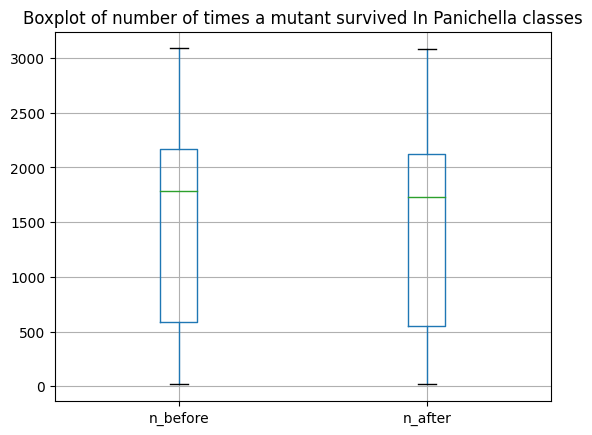

In [180]:

# Import libraries
import matplotlib.pyplot as plt
 
df = pd.read_csv('Results/Panichella_survived.csv', index_col=False)
# Plot
print(df)
df.boxplot(column=['n_before', 'n_after'])

# Optionally, you can set a title for the plot
plt.title('Boxplot of number of times a mutant survived In Panichella classes')



# Display the plot
plt.show()

In [201]:
def GetAllKilledByMutantsPanichella():
    #Open the panichella_subjects.txt file parse every line to list
    file = 'panichella_classes.txt'
    subjects = open(file, "r")
    panichella = subjects.readlines()
    # Replace the \n character except for the last one
    for i in range(len(panichella)):
        panichella[i] = panichella[i].replace("\n", "")


    df = pd.read_csv('Results/Panichella_killed.csv', index_col=False)
    # Get the results from the original and injected projects
    

    for class_name in panichella:
            file_original = "DumpsOriginal/" + class_name + '_original.txt'
            file_injected = "DumpsInjected/" + class_name + '_injected.txt'

            original_results = obtain_resume_dict_panichella_original(file_original)
            injected_results = obtain_resume_dict_panichella_injected(file_injected)
            for key in original_results.keys():

                original_survived  = process_mutants(original_results[key]['killed_mutants'])
                injected_survived = process_mutants(injected_results[key]['killed_mutants'])

                # add the mutation score to the dataframe
                top_original = look_survived_mutants(original_survived)
                top_injected = look_survived_mutants(injected_survived)
                
                for mutant in top_original.keys():
                    if df['mutant_name'].isin([mutant]).any():
                        df.loc[df['mutant_name'] == mutant, 'n_before'] += top_original[mutant]
                    else:
                        df.loc[len(df.index)] = [mutant, top_original[mutant], 0]
                for mutant in top_injected.keys():
                    if df['mutant_name'].isin([mutant]).any():
                        df.loc[df['mutant_name'] == mutant, 'n_after'] += top_injected[mutant]
                    else:
                        df.loc[len(df.index)] = [mutant, 0, top_injected[mutant]]
                    

            
            

    # Save the dataframe as a csv file
    df.to_csv(f"Results/Panichella_killed.csv", index=False)

In [202]:
file = open(f"Results/Panichella_killed.csv", "w")
# new dataframe with the columns survided_mutant_name, n_before, n_after
column_names = ['mutant_name', 'n_before', 'n_after']
df = pd.DataFrame(columns=column_names)
df.to_csv(f"Results/Panichella_killed.csv", index=False)

GetAllKilledByMutantsPanichella()


In [199]:
def GetAllSurvivedByClassPanichella():
    #Open the panichella_subjects.txt file parse every line to list
    file = 'panichella_classes.txt'
    subjects = open(file, "r")
    panichella = subjects.readlines()
    # Replace the \n character except for the last one
    for i in range(len(panichella)):
        panichella[i] = panichella[i].replace("\n", "")


    df = pd.read_csv('Results/Panichella_classes.csv', index_col=False)
    # Get the results from the original and injected projects
    

    for class_name in panichella:
        file_original = "DumpsOriginal/" + class_name + '_original.txt'
        file_injected = "DumpsInjected/" + class_name + '_injected.txt'

        original_results = obtain_resume_dict_panichella_original(file_original)
        injected_results = obtain_resume_dict_panichella_injected(file_injected)
        for key in original_results.keys():
            original_survived  = process_mutants(original_results[key]['survived_mutants'])
            injected_survived = process_mutants(injected_results[key]['survived_mutants'])
            # add the mutation score to the dataframe
            top_original = look_survived_mutants(original_survived)
            top_injected = look_survived_mutants(injected_survived)
            for mutantName in top_original.keys():
                if df['className'].isin([key]).any():
                    df.loc[df['className'] == key, 's_before'] += top_original[mutantName]
                else:
                    total = len(original_results[key]['survived_mutants']) + len(original_results[key]['killed_mutants']) 
                    k_before = len(original_results[key]['killed_mutants'])
                    df.loc[len(df.index)] = [key, top_original[mutantName], 0, k_before , 0, total, 0 , original_results[key]['mutation_score'], 0]
            for mutantName in top_injected.keys():
                if df['className'].isin([key]).any():
                    df.loc[df['className'] == key, 's_after'] += top_injected[mutantName]
                    total = len(injected_results[key]['survived_mutants']) + len(injected_results[key]['killed_mutants']) 
                    k_after = len(injected_results[key]['killed_mutants'])
                    df.loc[df['className'] == key, 'total_after'] = total
                    df.loc[df['className'] == key, 'k_after'] = k_after
                    df.loc[df['className'] == key, 'mutation_score_after'] = injected_results[key]['mutation_score']

                else:
                    total = len(injected_results[key]['survived_mutants']) + len(injected_results[key]['killed_mutants']) 
                    k_after = len(injected_results[key]['killed_mutants'])
                    df.loc[len(df.index)] = [key, 0, top_injected[mutantName],0,0, k_after, total, 0, injected_results[key]['mutation_score']]


            
    # Save the dataframe as a csv file
    df.to_csv(f"Results/Panichella_classes.csv", index=False)

In [200]:
file = open(f"Results/Panichella_classes.csv", "w")
# new dataframe with the columns survided_mutant_name, n_before, n_after
column_names = ['className', 's_before','s_after','k_before','k_after', 'total_before', 'total_after' , 'mutation_score_before', 'mutation_score_after']
df = pd.DataFrame(columns=column_names)
df.to_csv(f"Results/Panichella_classes.csv", index=False)

GetAllSurvivedByClassPanichella()


                                           className  s_before  s_after  \
0  net.sourceforge.squirrel_sql.client.mainframe....         3        3   
1  net.sourceforge.squirrel_sql.client.session.pa...      2922     2915   
2  net.sourceforge.squirrel_sql.client.update.gui...       168      168   
3  net.sourceforge.squirrel_sql.client.session.ma...       201      201   
4  com.eteks.sweethome3d.viewcontroller.PhotoCont...       216      150   
5  com.eteks.sweethome3d.viewcontroller.RoomContr...       135      135   
6  com.aelitis.azureus.core.instancemanager.impl....        31       33   
7          com.aelitis.azureus.core.nat.NATTraverser        52       52   
8  com.aelitis.azureus.core.peermanager.messaging...       199      204   
9  org.bouncycastle.asn1.pkcs.CertificationReques...        17       17   

   k_before  k_after  total_before  total_after mutation_score_before  \
0         0        0             3            3                     0   
1        22       29        

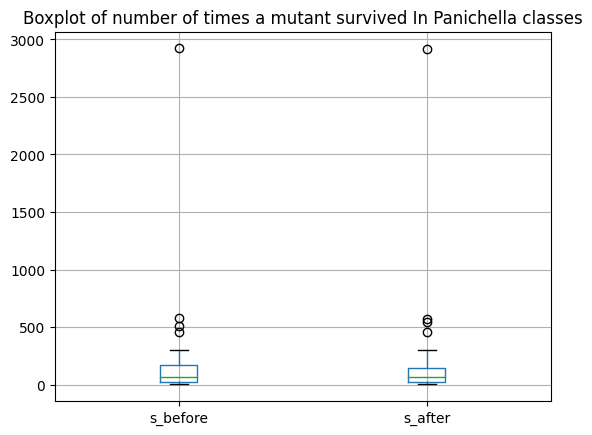

In [185]:

# Import libraries
import matplotlib.pyplot as plt
 
df = pd.read_csv('Results/Panichella_classes.csv', index_col=False)
# Plot
df.boxplot(column=['s_before', 's_after'])

# Optionally, you can set a title for the plot
plt.title('Boxplot of number of times a mutant survived In Panichella classes')



# Display the plot
plt.show()

In [186]:
def ReorderPanichella_classes():
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv('Results/Panichella_classes.csv')

    # Calculate the changes between 'nbefore' and 'nafter' columns
    df['changes'] = (df['s_after'] - df['s_before']).abs()

    # Sort the DataFrame based on the number of changes in descending order
    df_sorted = df.sort_values(by='changes', ascending=False)

    # Print the sorted DataFrame
    df_sorted.to_csv(f"Results/MostChangedPanichellaAbs.csv", index=False)

    df = pd.read_csv('Results/Panichella_classes.csv')

    # Calculate the changes between 'nbefore' and 'nafter' columns
    df['changes'] = df['s_after'] - df['s_before']
    # Sort the DataFrame based on the number of changes in descending order
    df_sorted = df.sort_values(by='changes', ascending=False)

    # Print the sorted DataFrame
    df_sorted.to_csv(f"Results/MostChangedPanichella.csv", index=False)

ReorderPanichella_classes()

In [187]:
def GetMutationScorePanichella():

    file = 'panichella_classes.txt'
    subjects = open(file, "r")
    panichella = subjects.readlines()

    for i in range(len(panichella)):
        panichella[i] = panichella[i].replace("\n", "")


    df = pd.read_csv('Results/MutationScorePanichella.csv', index_col=False)

    for class_name in panichella:
        file_original = "DumpsOriginal/" + class_name + '_original.txt'
        file_injected = "DumpsInjected/" + class_name + '_injected.txt'
        original_results = obtain_resume_dict_panichella_original(file_original)
        injected_results = obtain_resume_dict_panichella_injected(file_injected)
        for key in original_results.keys():
            try:
            # add the mutation score to the dataframe
                row = [key, original_results[key]['mutation_score'], injected_results[key]['mutation_score']]
                df.loc[len(df.index)] = row
            except:
                print('Not able to process class: ' + key)
    # Save the dataframe as a csv file
    df.to_csv(f"Results/MutationScorePanichella.csv", index=False)

In [188]:
file = open(f"Results/MutationScorePanichella.csv", "w")
# new dataframe with the columns survided_mutant_name, n_before, n_after
column_names = ["class_name",'mutation_score_before', 'mutation_score_after']
df = pd.DataFrame(columns=column_names)
df.to_csv(f"Results/MutationScorePanichella.csv", index=False)

GetMutationScorePanichella()

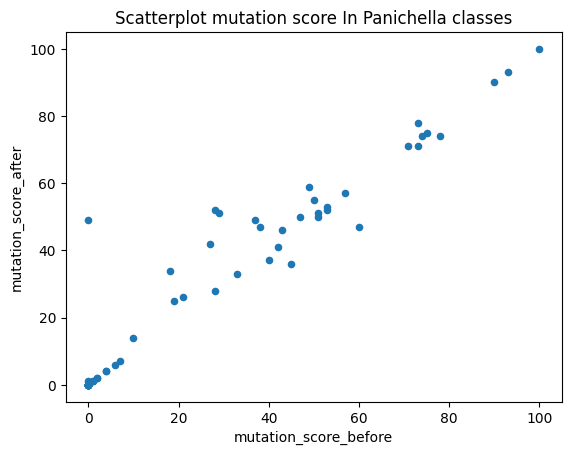

In [189]:

# Import libraries
import matplotlib.pyplot as plt
 
df = pd.read_csv('Results/MutationScorePanichella.csv', index_col=False)
# Plot
df.plot.scatter(x='mutation_score_before' , y='mutation_score_after')

# Optionally, you can set a title for the plot
plt.title('Scatterplot mutation score In Panichella classes')



# Display the plot
plt.show()

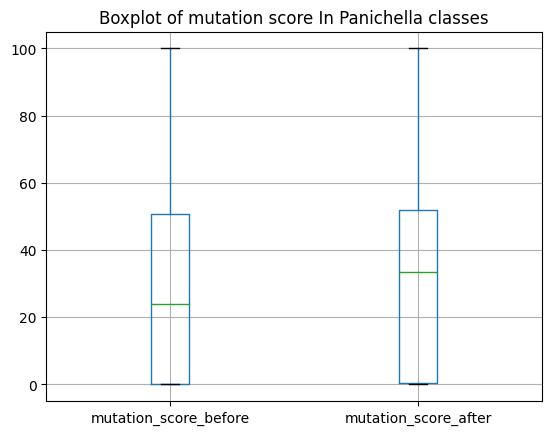

In [190]:

# Import libraries
import matplotlib.pyplot as plt
 
df = pd.read_csv('Results/MutationScorePanichella.csv', index_col=False)
# Plot
df.boxplot(column=['mutation_score_before', 'mutation_score_after'])

# Optionally, you can set a title for the plot
plt.title('Boxplot of mutation score In Panichella classes')



# Display the plot
plt.show()

In [191]:
def GetMutationScorePanichellaDepurado():

    file = 'panichella_classes.txt'
    subjects = open(file, "r")
    panichella = subjects.readlines()

    for i in range(len(panichella)):
        panichella[i] = panichella[i].replace("\n", "")


    df = pd.read_csv('Results/MutationScorePanichellaDepurado.csv', index_col=False)

    for class_name in panichella:
        file_original = "DumpsOriginal/" + class_name + '_original.txt'
        file_injected = "DumpsInjected/" + class_name + '_injected.txt'
        original_results = obtain_resume_dict_panichella_original(file_original)
        injected_results = obtain_resume_dict_panichella_injected(file_injected)
        for key in original_results.keys():
            try:
            # add the mutation score to the dataframe
                if original_results[key]['mutation_score'] != injected_results[key]['mutation_score']:
                    row = [key, original_results[key]['mutation_score'], injected_results[key]['mutation_score']]
                    df.loc[len(df.index)] = row
            except:
                print('Not able to process class: ' + key)
    # Save the dataframe as a csv file
    df.to_csv(f"Results/MutationScorePanichellaDepurado.csv", index=False)

In [192]:
file = open(f"Results/MutationScorePanichellaDepurado.csv", "w")
# new dataframe with the columns survided_mutant_name, n_before, n_after
column_names = ["class_name",'mutation_score_before', 'mutation_score_after']
df = pd.DataFrame(columns=column_names)
df.to_csv(f"Results/MutationScorePanichellaDepurado.csv", index=False)

GetMutationScorePanichellaDepurado()

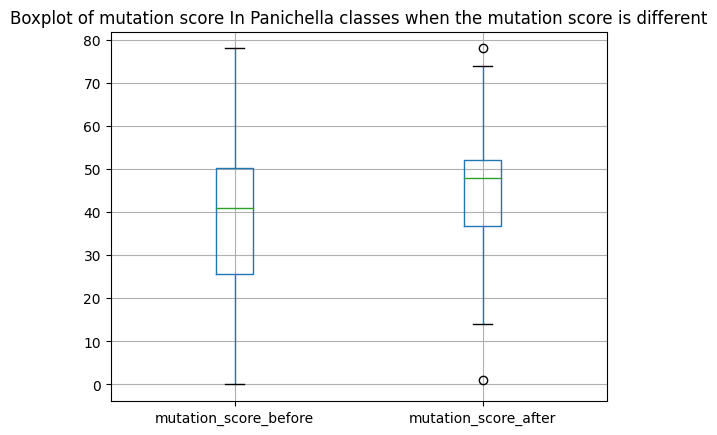

In [193]:

# Import libraries
import matplotlib.pyplot as plt
 
df = pd.read_csv('Results/MutationScorePanichellaDepurado.csv', index_col=False)
# Plot
df.boxplot(column=['mutation_score_before', 'mutation_score_after'])

# Optionally, you can set a title for the plot
plt.title('Boxplot of mutation score In Panichella classes when the mutation score is different')



# Display the plot
plt.show()

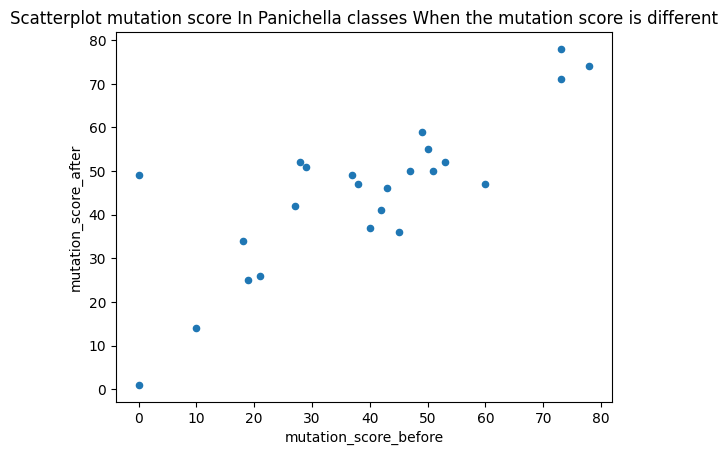

In [194]:

# Import libraries
import matplotlib.pyplot as plt
 
df = pd.read_csv('Results/MutationScorePanichellaDepurado.csv', index_col=False)
# Plot
df.plot.scatter(x='mutation_score_before' , y='mutation_score_after')

# Optionally, you can set a title for the plot
plt.title('Scatterplot mutation score In Panichella classes When the mutation score is different')



# Display the plot
plt.show()